In [1]:
import numpy             as np
import gvar              as gv
import matplotlib.pyplot as plt
import pandas            as pd
import lsqfit
import itertools
import sys
from tqdm import tqdm

In [2]:
from b2heavy.ThreePointFunctions.utils import read_config_fit, dump_fit_object
from b2heavy.FnalHISQMetadata import params as mdata

sys.path.append('/Users/pietro/code/software/B2heavy/routines')
from routines.fit_2pts_dispersion_relation import mom_to_p2, extract_energies
from routines.fit_2pts_dispersion_relation import dispersion_relation_lsqfit as disprel
from routines.fit_2pts_dispersion_relation import dispersion_relation        as disprel_plot

In [3]:
frm = '/Users/pietro/code/data_analysis/data/QCDNf2p1stag/B2heavy/report'
mes = 'D'
JK = True
JKFIT = False

enslist = [['MediumCoarse','Coarse-2','Coarse-1','Coarse-Phys'],['Fine-1','Fine-Phys','SuperFine']]

In [4]:
def fit_disp_rel(e0:dict, Lvol=1., priors=None):
    pv = [2*np.pi/Lvol*np.array([float(px) for px in m]) for m in e0]

    psort = list(e0.keys())
    psort.sort(key=mom_to_p2)

    e0vec = np.array([e0[p] for p in psort])
    yfit = e0vec**2

    if e0vec.ndim==2:
        yfit = gv.gvar(
            yfit.mean(axis=1),
            np.cov(yfit) * (yfit.shape[-1]-1)
        )

    fit = lsqfit.nonlinear_fit(
        data  = (pv,yfit),
        fcn   = disprel,
        prior = priors
    )

    return fit


def fit_disp_rel_jk(fit:lsqfit.nonlinear_fit, e0):
    psort = list(e0.keys())
    psort.sort(key=mom_to_p2)
    e0vec = np.array([e0[p] for p in psort])
    assert e0vec.ndim==2

    yfit = e0vec**2

    aux = []
    for jk in tqdm(range(yfit.shape[-1])):
        f = lsqfit.nonlinear_fit(
            data  = (fit.x,yfit[:,jk],gv.evalcov(fit.y)),
            fcn   = fit.fcn,
            prior = fit.prior 
        )
        aux.append(f.pmean)
    df = pd.DataFrame(aux)
    fitp = gv.gvar(
        df.mean().values,
        df.cov().values*(df.shape[0]-1)
    )
    
    return {c: fitp[i] for i,c in enumerate(df.columns)}


In [5]:
def plot_disp_rel(ax,fit,popt,Lvol,**kwargs):
    p2 = np.array([sum(np.array(p)**2) for p in fit.x])
    ax.errorbar(p2,gv.mean(fit.y),gv.sdev(fit.y),**kwargs)

    plist = [np.sqrt([x/3,x/3,x/3]) for x in np.arange(0,max(p2)+0.1,0.01)]
    xplot = [sum(p**2) for p in plist]
    fitpar = [popt[k] for k in ['M1','M2','M4','w4']]
    fplot = [disprel_plot(p,*fitpar) for p in plist]
    ax.fill_between(xplot,gv.mean(fplot)-gv.sdev(fplot),gv.mean(fplot)+gv.sdev(fplot),alpha=0.2)

    dp = p2[1]-p2[0]
    ax.set_xlim(xmax=max(p2)+dp)

    de2 = abs((fit.y[-1]-fit.y[-2]).mean)
    ax.set_ylim(ymax=max(gv.mean(fit.y))+de2)


    return

In [6]:
priors = dict(
    M1 = gv.gvar(0.5,1.5),
    M2 = gv.gvar(0.5,1.5),
    M4 = gv.gvar(0.5,1.5),
    w4 = gv.gvar(0.5,1.5)
)

100%|██████████| 64/64 [00:00<00:00, 238.57it/s]


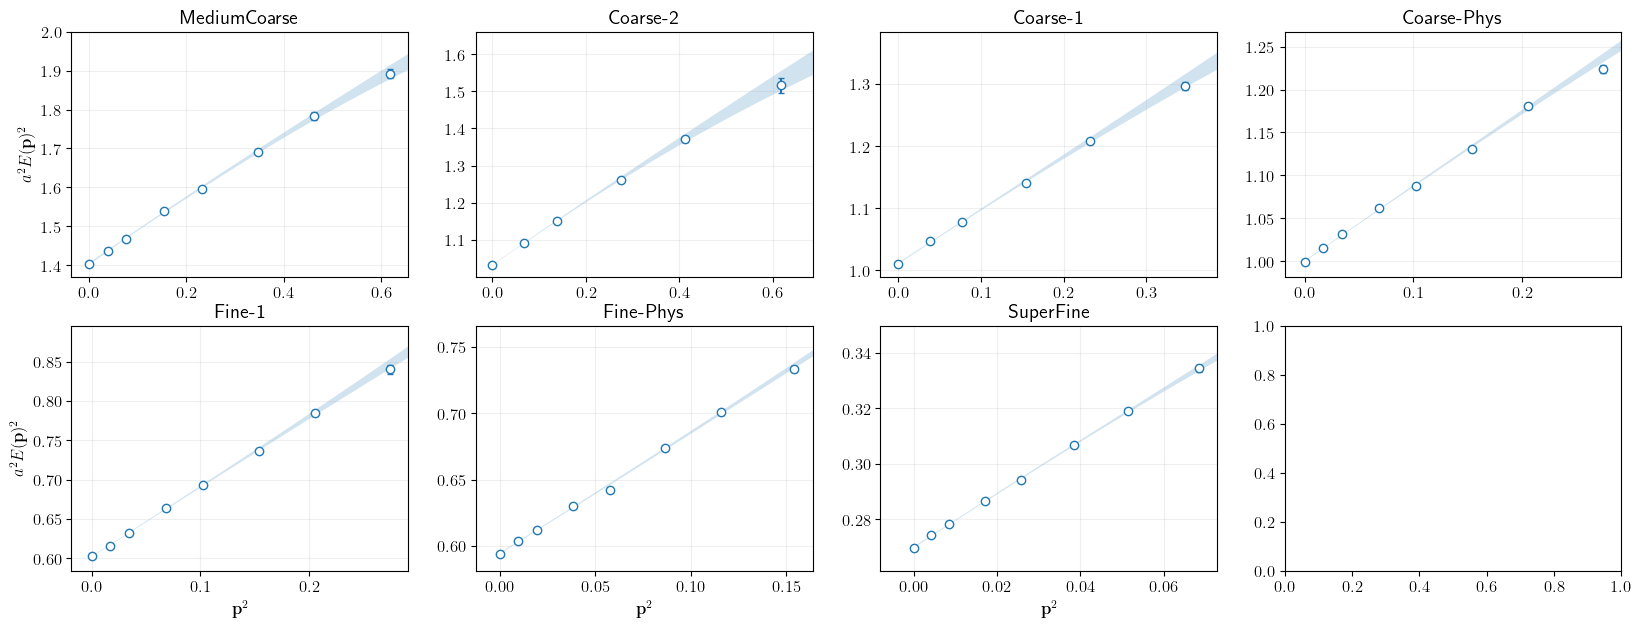

In [18]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 12

fig, ax = plt.subplots(2,4,figsize=(20,7))

ergs = {}
moms = {}
fits = []
for i,row in enumerate(enslist):
    for j,ens in enumerate(row):
        Lvol   = mdata(ens)['L']

        tag = f'{ens}_{mes}'

        es = extract_energies(ens,mes,jk=True,readfrom=frm,sort=True)
        fit = fit_disp_rel(es, Lvol=Lvol, priors=priors)
        popt = fit_disp_rel_jk(fit,es)        

        plot_disp_rel(ax[i,j], fit, popt, Lvol=Lvol, fmt='o', ecolor='C0', mfc='w', capsize=2.5)

        fits.append(popt)
        ergs[ens] = fit.y
        moms[ens] = fit.x

        ax[i,j].set_title(ens)
        ax[i,j].grid(alpha=0.2)

        if j==0:
            ax[i,j].set_ylabel(r'$a^2 E(\mathbf{p})^2$')
        if i==1:
            ax[i,j].set_xlabel(r'$\mathbf{p}^2$')



In [26]:
res = pd.DataFrame(fits).set_index(np.concatenate(enslist))
print(res)

                       M1         M2         M4        w4
MediumCoarse   1.1845(12)  1.342(49)   1.03(13)  0.03(19)
Coarse-2      1.01558(49)  1.146(26)   0.94(13)  0.14(37)
Coarse-1      1.00565(62)  1.152(35)   1.04(27)  0.36(45)
Coarse-Phys   1.00021(38)  1.136(28)   1.11(29)  0.72(38)
Fine-1        0.77601(35)  0.878(17)   0.93(19)  0.63(52)
Fine-Phys     0.77108(33)  0.858(21)   1.01(33)  0.30(59)
SuperFine     0.51949(25)  0.531(15)  0.455(64)  0.58(60)


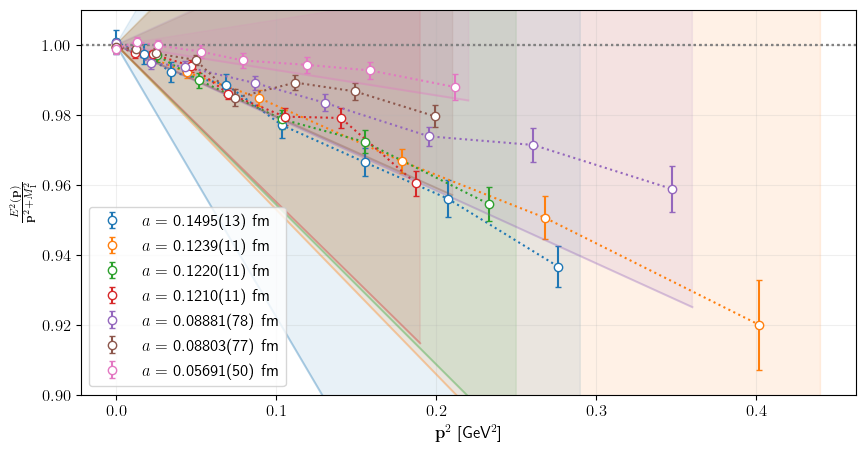

In [137]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 12

plt.figure(figsize=(10,5))
ax = plt.subplot(1,1,1)


for i,ens in enumerate(ergs):
    alphas = mdata(ens)['alphaS']
    a = mdata(ens)['aSpc'].mean

    es = ergs[ens]
    p2 = np.sum(np.array(moms[ens])**2,axis=1)
    
    num = es
    den = p2 + res['M1'].loc[ens]**2

    xplot = p2/a**2/100
    yplot = num/den

    lbl = r'$a=$ '+str(mdata(ens)['aSpc'])+' fm'

    ax.errorbar(xplot,gv.mean(yplot),gv.sdev(yplot),fmt='o', ecolor=f'C{i}', mfc='w', capsize=2.5,label=lbl)
    ax.plot(xplot,gv.mean(yplot),linestyle=':',marker=',',color=f'C{i}')
    ax.axhline(1.,color='gray',alpha=0.5,linestyle=':')

    endp = max(xplot)+xplot[1]
    xcone = np.arange(0,endp,0.01)
    ycone = xcone*100 * alphas * a**2
    ax.fill_between(xcone, 1+ycone,1-ycone,alpha=0.1,color=f'C{i}')
    ax.plot(xcone, 1-ycone,alpha=0.3,color=f'C{i}')

# ax.set_xlim(xmin=-0.01,xmax=endp-0.01)

ax.set_ylabel(r'$\frac{E^2(\mathbf{p})}{\mathbf{p}^2 + M_1^2}$')
# ax.set_xlabel(r'$a^2\mathbf{p}^2$')
ax.set_xlabel(r'$\mathbf{p}^2$ [GeV$^2$]')
ax.set_ylim(ymax=1.01,ymin=0.9)


ax.grid(alpha=0.2)
ax.legend()